```
Running experiments with the Ensemble Kalman Filter

Copyright (C) 2020  SINTEF Digital

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import os
import sys

#Import packages we need
import numpy as np
import pandas as pd

#Helpful during development
import importlib
#importlib.reload(module)

import datetime
import time

from IPython.display import display

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc


#Set large figure sizes
#plt.rcParams["animation.html"] = "jshtml" #Javascript 
plt.rcParams["animation.html"] = "html5" #mp4
plt.rcParams["figure.dpi"] = 100.0 #highres movies/plots

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

import Lorenz96
import Ensemble
import DataDrivenANN

In [2]:
store_in_dropbox=True
dropbox_folder = '/home/havahol/Dropbox/phd/presentations/trial_lecture/'

colors = ['xkcd:scarlet', 'xkcd:light blue grey', 'xkcd:dark grey blue']


# Read observations and initial conditions

In [3]:
## Read observations

### observation every 0.2:
#observation_file = np.load('data/observations_2020_05_10-20_19_36/observations.npz')

### observation every 0.1:
observation_file =  np.load('data/observations_2020_05_10-20_28_26/observations.npz')

observation_indices=observation_file['observation_indices']
observations=observation_file['observations']
observation_time_indices=observation_file['observation_time_indices']
observation_times=observation_file['observation_times']
L96_truth_X=observation_file['truth']
H = observation_file['H']

init_X = L96_truth_X[0,:].copy()

print(observation_indices.shape)
init_X

H

(4,)


array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.]])

## Make physical ensemble 

In [4]:
%%time
importlib.reload(Ensemble)

end_T = 5
Ne = 500
monte_carlo_input = {
    'init_X': init_X,
    'num_layers': 1,
    'end_T': end_T
   }

ensemble = Ensemble.Ensemble(Ne, physical_model_params=monte_carlo_input)
ensemble.perturb_all_states(scale=1)


CPU times: user 48 ms, sys: 12 ms, total: 60 ms
Wall time: 56.3 ms


# Make test functions for EnKF

### Run to first observation

In [59]:
def step_to_observation(ensemble, observation_times, obs_number):
    ensemble.step(observation_times[obs_number], keras_step=False)

In [6]:
step_to_observation(ensemble, observation_times, 0)

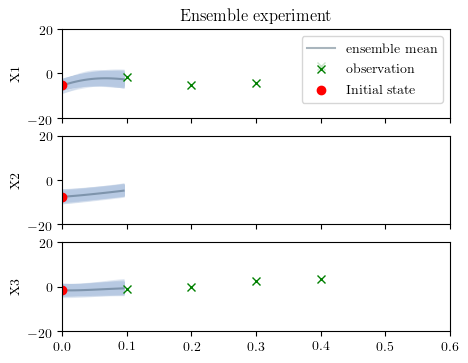

In [7]:
ensemble_mean = ensemble.getActualMean()

### CLOSE UP ON to first variables
num_vars = 3

fig, axs = plt.subplots(num_vars, figsize=(5,4), sharex=True)
t_axis = np.arange(ensemble.ensemble[0].num_timesteps+1)*ensemble.ensemble[0].dt
it = ensemble.ensemble[0].it
for i in range(num_vars):
    
    # Plot ensemble:
    for member in ensemble.ensemble:
        axs[i].plot(t_axis[:it], member.X[:it,i], color=colors[1], alpha=0.4)
    axs[i].plot(t_axis[:it], ensemble_mean[:it,i], color=colors[2], alpha=0.4, label='ensemble mean')
    
    
    axs[i].set_ylabel('X'+str(i+1))
    axs[i].set_ylim([-20,20])
    axs[i].set_xlim([t_axis[0],t_axis[observation_time_indices[5]]])

    if i%2 == 0:
        obs_index=i//2
        axs[i].plot(observation_times[:4], observations[:4,obs_index], 'x',color='green', label='observation')
    
axs[0].legend(loc=1)
axs[0].set_title('Ensemble experiment')
#plt.tight_layout()

for i in range(num_vars):
    axs[i].plot(t_axis[0], L96_truth_X[0,i],  'o',color='red', label='Initial state')
    
axs[0].legend(loc=1)
if store_in_dropbox:
    fig.savefig(dropbox_folder+"enkf_first_prior.pdf")    
    fig.savefig(dropbox_folder+"enkf_first_prior.png", dpi=200)

In [60]:
def getStateCovariance(ensemble):
    ens_mean = ensemble.getCurrentMean()
    #print(ens_mean.shape)
    cov = np.zeros((8,8))
    for member in ensemble.ensemble:
        cov += np.outer(member.getActualState() - ens_mean, member.getActualState() - ens_mean)
    cov *= (1/(ensemble.Ne - 1))
    return cov

#cov = getStateCovariance(ensemble)
#plt.imshow(cov)
#plt.colorbar()

In [61]:
def enkf(ensemble, observation):
    #print(observation)
    
    P = getStateCovariance(ensemble)
    
    S = np.dot(H, np.dot(P, H.T))
    K = np.dot(P, np.dot(H.T, np.linalg.inv(S)))
    #print(K)
    #plt.imshow(K)
    
    for i in range(ensemble.Ne):
        
        X_f = ensemble.ensemble[i].getActualState()
        d = observation - np.dot(H, X_f) + np.random.normal(0,1,4)
        
        X_a = X_f + np.dot(K, d)
        ensemble.ensemble[i].setCurrentState(X_a, is_normalized=False)
        
    
    
#enkf(ensemble, observations[0,:])


In [76]:
def plot_local(ensemble, filename, num_vars=3):

    ensemble_mean = ensemble.getActualMean()

    ### CLOSE UP ON to first variables
    num_vars = 4

    fig, axs = plt.subplots(num_vars, figsize=(5,4), sharex=True)
    t_axis = np.arange(ensemble.ensemble[0].num_timesteps+1)*ensemble.ensemble[0].dt
    it = ensemble.ensemble[0].it
    for i in range(num_vars):

        # Plot ensemble:
        for member in ensemble.ensemble:
            X = member.getActualTimeseries()[:it,i]
            axs[i].plot(t_axis[:it], X, color=colors[1], alpha=0.4)
        axs[i].plot(t_axis[:it], ensemble_mean[:it,i], color=colors[2], alpha=0.4, label='ensemble mean')


        axs[i].set_ylabel('X'+str(i+1))
        axs[i].set_ylim([-20,20])
        axs[i].set_xlim([t_axis[0],t_axis[observation_time_indices[5]]])

        if i%2 == 0:
            obs_index=i//2
            axs[i].plot(observation_times[:4], observations[:4,obs_index], 'x',color='green', label='observation')

    axs[0].legend(loc=1)
    axs[0].set_title('Ensemble experiment')
    #plt.tight_layout()

    for i in range(num_vars):
        axs[i].plot(t_axis[0], L96_truth_X[0,i],  'o',color='red', label='Initial state')

    axs[0].legend(loc=1)
    if store_in_dropbox:
        fig.savefig(dropbox_folder+filename+".pdf")    
        fig.savefig(dropbox_folder+filename+".png", dpi=200)

# Put everything together - make new ensemble and run all observations

In [62]:
def outer_loop(ensemble, observations, observation_times, title):
    
    for obs_number in range(len(observation_times)):
    
        # Step ensemble to observation
        step_to_observation(ensemble, observation_times, obs_number)
        
        # Do ensemble Kalman filter
        enkf(ensemble, observations[obs_number,:])
        
        print('Done observation: ', obs_number)
        
        if obs_number < 7:
            filename = title+str(obs_number)
            plot_local(ensemble, filename)
        

In [13]:
%%time
importlib.reload(Ensemble)

end_T = 5
Ne = 100
monte_carlo_input = {
    'init_X': init_X,
    'num_layers': 1,
    'end_T': end_T
   }

ensemble = Ensemble.Ensemble(Ne, physical_model_params=monte_carlo_input)
ensemble.perturb_all_states(scale=1)


CPU times: user 16 ms, sys: 4 ms, total: 20 ms
Wall time: 14.9 ms


Done observation:  0
Done observation:  1
Done observation:  2
Done observation:  3
Done observation:  4
Done observation:  5
Done observation:  6
Done observation:  7
Done observation:  8
Done observation:  9
Done observation:  10
Done observation:  11
Done observation:  12
Done observation:  13
Done observation:  14
Done observation:  15
Done observation:  16
Done observation:  17
Done observation:  18
Done observation:  19
Done observation:  20
Done observation:  21
Done observation:  22
Done observation:  23
Done observation:  24
Done observation:  25
Done observation:  26
Done observation:  27
Done observation:  28
Done observation:  29
CPU times: user 1min 5s, sys: 2.56 s, total: 1min 8s
Wall time: 29 s


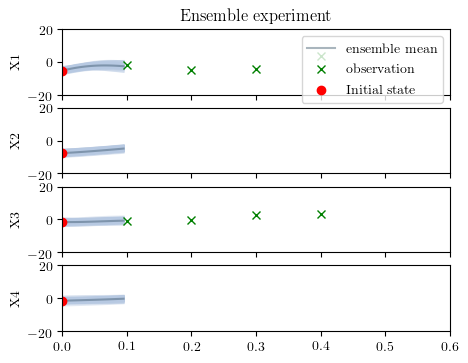

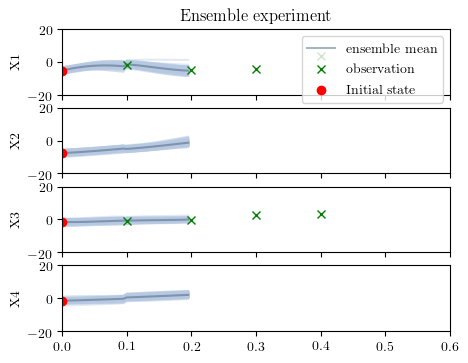

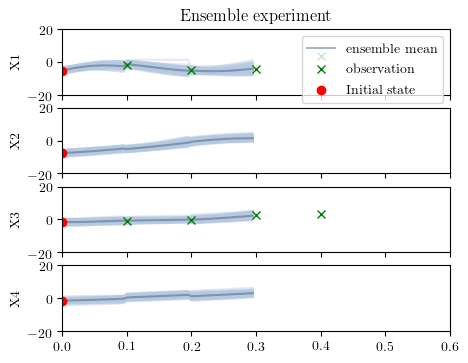

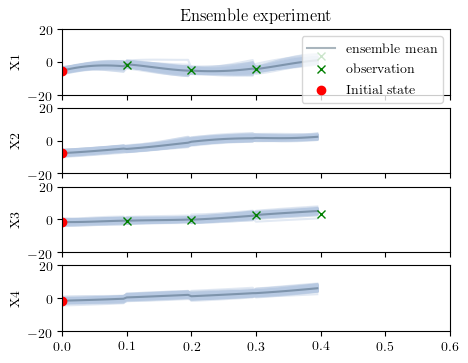

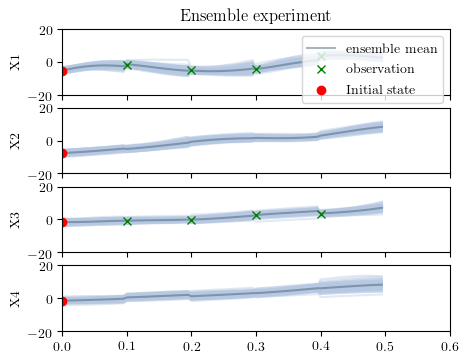

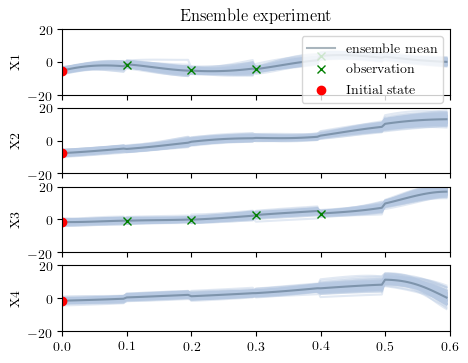

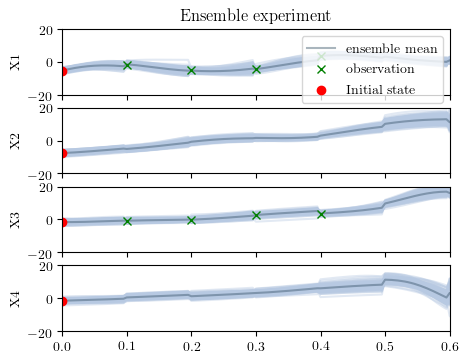

In [14]:
%%time
outer_loop(ensemble, observations, observation_times, title='enkf_physics_')


In [82]:
def plot_full_fig(ensemble, filename, title):
    fig, axs = plt.subplots(8, figsize=(10,8), sharex=True)
    t_axis = np.arange(ensemble.ensemble[0].num_timesteps+1)*ensemble.ensemble[0].dt
    sim_it = ensemble.ensemble[0].it
    for i in range(8):

        # Plot ensemble:
        for member in ensemble.ensemble:
            X = member.getActualTimeseries()[:sim_it,i]
            axs[i].plot(t_axis[:sim_it], X, color=colors[1], alpha=0.4)

        # Plot mean:
        axs[i].plot(t_axis[:sim_it], ensemble.getActualMean()[:sim_it,i], color=colors[2], label='ensemble mean')

        #axs[i].plot(t_axis, L96_truth_X[:,i], color=colors[0], label='truth')

        axs[i].set_ylabel('X'+str(i+1))
        axs[i].set_ylim([-20,20])
        axs[i].set_xlim([0, t_axis[-1]])

    member.X[:,i].shape
    axs[0].legend(loc=1)
    axs[0].set_title(title)
    #plt.tight_layout()
    if store_in_dropbox:
        fig.savefig(dropbox_folder+filename+".pdf")    
        fig.savefig(dropbox_folder+filename+".png", dpi=200)


    for i in range(8):
        if i%2 == 0:
            obs_index=i//2
            axs[i].plot(observation_times, observations[:,obs_index], 'x',color='green', label='obs')
    axs[0].legend(loc=1)
    if store_in_dropbox:
        fig.savefig(dropbox_folder+filename+"_and_obs.pdf")    
        fig.savefig(dropbox_folder+filename+"_and_obs.png", dpi=200)

    for i in range(8):
        axs[i].plot(t_axis, L96_truth_X[:,i], color=colors[0], label='truth')

    axs[0].legend(loc=1)
    if store_in_dropbox:
        fig.savefig(dropbox_folder+filename+"_and_obs_and_truth.pdf")    
        fig.savefig(dropbox_folder+filename+"_and_obs_and_truth.png", dpi=200)

plot_full_fig(ensemble, 'physics_driven_enkf_all', title='Ensemble Kalman filter with physics-driven model')

TypeError: plot_full_fig() missing 1 required positional argument: 'title'

In [16]:
%%time
ensemble.step(end_T)
ensemble.update_mean()


CPU times: user 13.7 s, sys: 0 ns, total: 13.7 s
Wall time: 13.6 s


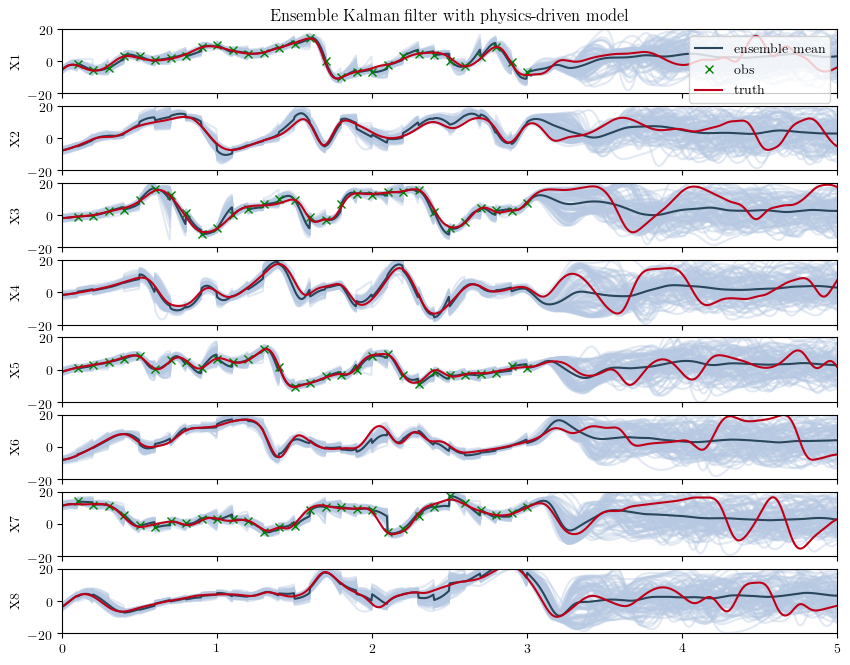

In [17]:
plot_full_fig(ensemble, 'physics_driven_enkf_all_forecast', title='Ensemble Kalman filter with physics-driven model')

# Check if this works with a data-driven ensemble

In [77]:
# Read data-driven ANN model
importlib.reload(DataDrivenANN)
model = DataDrivenANN.create_model_ANN()

# Load weights
model.load_weights('data/ANN_weights_global_2020_05_04-18_04_47/weights', by_name=False)

# Read statistical info
init_folder = 'data/training_data_2020_05_04-15_13_21/'
statistical_properties = np.load(init_folder+'mean_and_stddev.npz')
mean = statistical_properties['mean']
stddev = statistical_properties['stddev']

In [78]:
%%time
end_T = 5
Ne = 10
monte_carlo_input = {
    'data_driven_model': model,
    'init_X': init_X,
    'is_normalized': False,
    'mean': mean,
    'stddev': stddev,
    'end_T': 5
   }

ann_ensemble = DataDrivenANN.DataDrivenEnsemble(50, datadriven_model_params=monte_carlo_input)
ann_ensemble.perturb_all_states(scale=1)





CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.39 ms


Done observation:  0
Done observation:  1
Done observation:  2
Done observation:  3
Done observation:  4
Done observation:  5
Done observation:  6
Done observation:  7
Done observation:  8
Done observation:  9
Done observation:  10
Done observation:  11
Done observation:  12
Done observation:  13
Done observation:  14
Done observation:  15
Done observation:  16
Done observation:  17
Done observation:  18
Done observation:  19
Done observation:  20
Done observation:  21
Done observation:  22
Done observation:  23
Done observation:  24
Done observation:  25
Done observation:  26
Done observation:  27
Done observation:  28
Done observation:  29


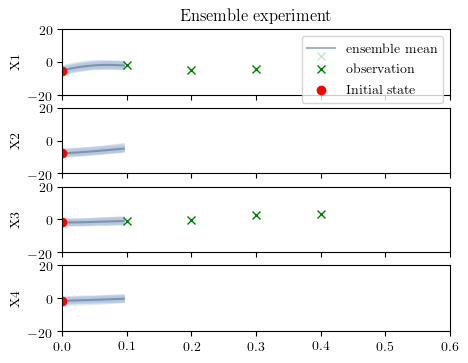

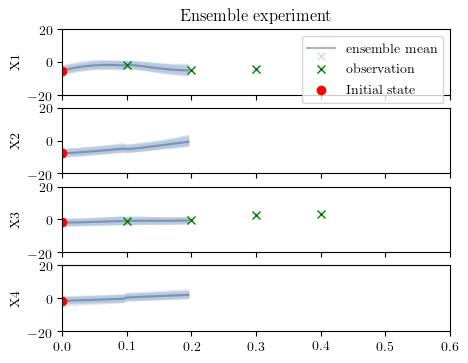

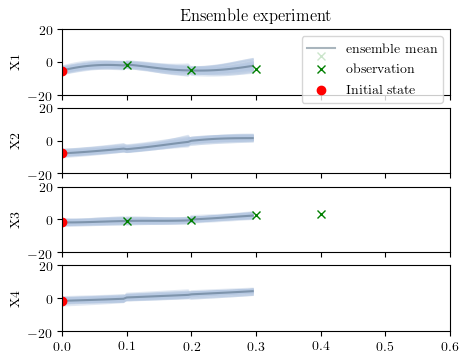

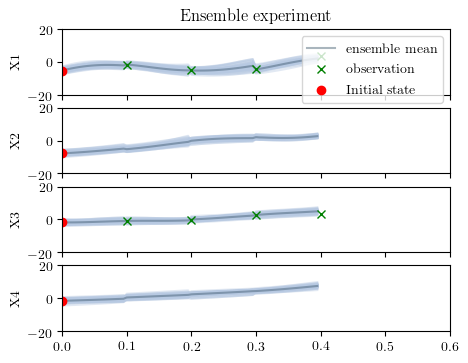

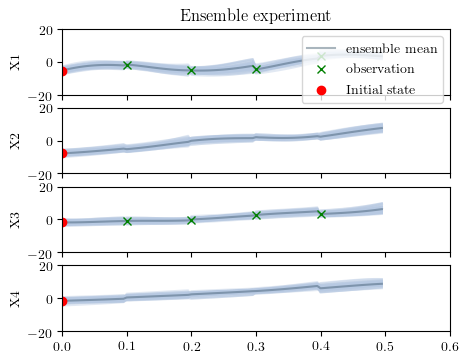

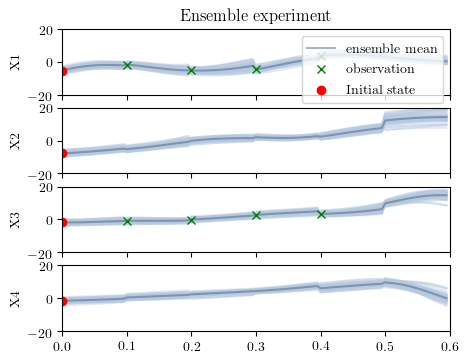

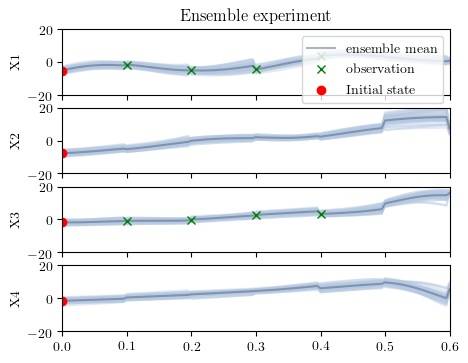

In [79]:
#%%time
outer_loop(ann_ensemble, observations, observation_times, title='enkf_datadriven_ANN_')


In [80]:
%%time
ann_ensemble.step(end_T, keras_step=False)
ann_ensemble.update_mean()

CPU times: user 7min 23s, sys: 27.2 s, total: 7min 50s
Wall time: 59.7 s


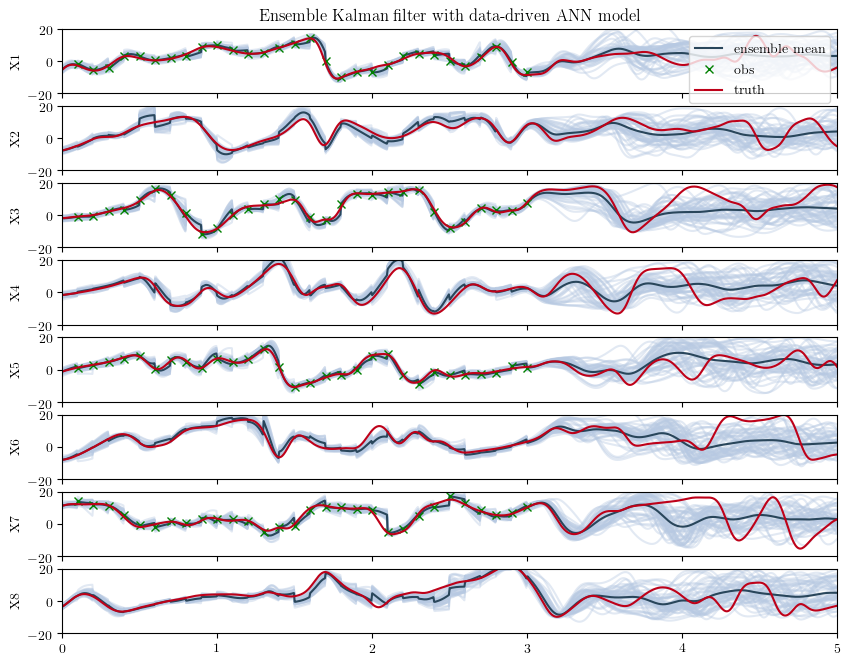

In [83]:
plot_full_fig(ann_ensemble, 'enkf_datadriven_ANN_all_forecast', title='Ensemble Kalman filter with data-driven ANN model')